In [1]:
import os
import numpy as np
import pandas as pd
from math import acos, degrees
from itertools import combinations
from numpy.linalg import norm
from scipy.spatial import cKDTree
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# --- Function Definitions ---
def parse_obj(filepath):
    vertices, edges = [], []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = list(map(float, line.strip().split()[1:4]))
                vertices.append(parts)
            elif line.startswith('l '):
                i, j = map(int, line.strip().split()[1:3])
                edges.append((i - 1, j - 1))  # convert to 0-based
    return np.array(vertices), edges

def compute_features(vertices, edges, k_neighbors=3):
    edge_set = set((min(i, j), max(i, j)) for i, j in edges)
    tree = cKDTree(vertices)

    features = []
    for i, j in combinations(range(len(vertices)), 2):
        p1, p2 = vertices[i], vertices[j]
        vec = p2 - p1
        dist = norm(vec)
        midpoint = (p1 + p2) / 2
        midpoint_height = midpoint[2]
        elevation_diff = abs(p1[2] - p2[2])

        horizontal = vec.copy(); horizontal[2] = 0
        angle_with_horizontal = degrees(acos(
            np.clip(np.dot(vec, horizontal) / (norm(vec) * norm(horizontal) + 1e-6), -1, 1)
        ))

        # Local density
        density_i = len(tree.query_ball_point(p1, r=2.0))
        density_j = len(tree.query_ball_point(p2, r=2.0))
        local_density = (density_i + density_j) / 2

        # Planarity score
        def get_planarity_score(point):
            _, idx = tree.query(point, k=k_neighbors)
            neighbor_pts = vertices[idx]
            cov = np.cov(neighbor_pts.T)
            eigvals = np.linalg.eigvalsh(cov)
            return eigvals[0] / (eigvals.sum() + 1e-6)

        planarity = (get_planarity_score(p1) + get_planarity_score(p2)) / 2

        # Normals
        def get_normal(point):
            _, idx = tree.query(point, k=k_neighbors)
            neighbor_pts = vertices[idx]
            cov = np.cov(neighbor_pts.T)
            eigvals, eigvecs = np.linalg.eigh(cov)
            return eigvecs[:, np.argmin(eigvals)]

        n1 = get_normal(p1)
        n2 = get_normal(p2)
        normal_diff = degrees(acos(np.clip(np.dot(n1, n2), -1, 1)))

        # Angle to other connected edges from p1
        angles = []
        for k in range(len(vertices)):
            if k != j and ((i, k) in edge_set or (k, i) in edge_set):
                vec2 = vertices[k] - p1
                angle = degrees(acos(
                    np.clip(np.dot(vec, vec2) / (norm(vec) * norm(vec2) + 1e-6), -1, 1)
                ))
                angles.append(angle)
        angle_to_others = np.mean(angles) if angles else 0

        # Label
        label = int((i, j) in edge_set or (j, i) in edge_set)

        features.append({
            'v1': i, 'v2': j,
            'distance': dist,
            'midpoint_height': midpoint_height,
            'angle_with_horizontal': angle_with_horizontal,
            'elevation_difference': elevation_diff,
            'local_density': local_density,
            'planarity_score': planarity,
            'normal_difference': normal_diff,
            'angle_to_other_edges': angle_to_others,
            'label': label
        })

    return features

# --- Feature Extraction ---
folder_path = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\dataset\Entry-level\train\wireframe"
all_features = []

for file in tqdm(os.listdir(folder_path)):
    if file.endswith(".obj"):
        full_path = os.path.join(folder_path, file)
        try:
            verts, edgelist = parse_obj(full_path)
            feats = compute_features(verts, edgelist)
            for f in feats:
                f["file"] = file
            all_features.extend(feats)
        except Exception as e:
            print(f"Error processing {file}: {e}")

# --- Save Raw Feature CSV ---
df = pd.DataFrame(all_features)
df.to_csv("raw_vertex_pair_features.csv", index=False)

# --- Apply SMOTE ---
X = df.drop(columns=["v1", "v2", "file", "label"])
y = df["label"]

# Scale before SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# --- Add v1 and v2 back to the resampled data ---
# After SMOTE, you can add 'v1' and 'v2' back to the resampled data.
# For this, we need to use the original `v1`, `v2` values from the dataset before resampling.
# We can assign the original `v1` and `v2` values back to the resampled dataset.

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Create a DataFrame from resampled data

# Re-adding the 'v1' and 'v2' columns
df_resampled["v1"] = df["v1"].iloc[:len(df_resampled)]
df_resampled["v2"] = df["v2"].iloc[:len(df_resampled)]

# Add 'label' column to the resampled data
df_resampled["label"] = y_resampled

# --- Save the balanced dataset with v1, v2, and label ---
df_resampled.to_csv("balanced_features_with_v1_v2_and_labels_final.csv", index=False)
print("Balanced dataset with 'v1', 'v2', and 'label' columns saved.")

100%|██████████| 5705/5705 [01:31<00:00, 62.36it/s] 


Balanced dataset with 'v1', 'v2', and 'label' columns saved.


C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [11:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


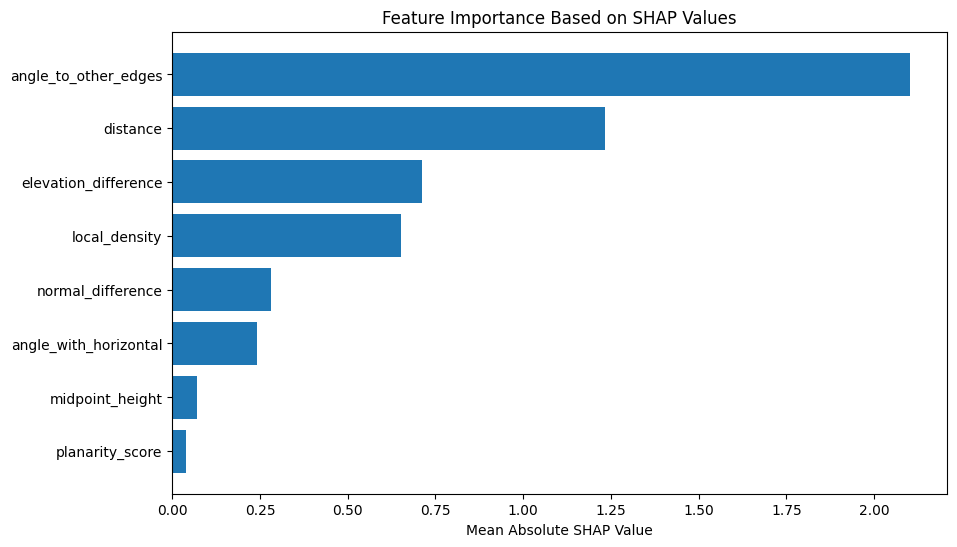

Updated dataset without the two least important features saved.


In [3]:
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv('balanced_features_with_v1_v2_and_labels_final.csv')

# Step 2: Separate features and target
drop_columns = ["v1", "v2", "label"]
drop_columns = [col for col in drop_columns if col in df.columns]
X = df.drop(columns=drop_columns)
y = df["label"]

# Step 3: Train an XGBoost classifier
# Convert data into DMatrix format, which is optimized for XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Step 4: Apply SHAP to calculate feature importance
explainer = shap.Explainer(bst)
shap_values = explainer(X)

# Step 5: Rank features based on SHAP importance values
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': shap_importance})

# Sort features by importance
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

# Plot the SHAP importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Based on SHAP Values')
plt.gca().invert_yaxis()
plt.show()

# Step 6: Remove the two least important features
least_important_features = feature_importance.tail(2)["feature"].tolist()
X_updated = X.drop(columns=least_important_features)

# Step 7: Add the retained columns v1, v2, and label back
X_updated["v1"] = df["v1"]
X_updated["v2"] = df["v2"]
X_updated["label"] = df["label"]

# Step 8: Save the updated dataset
X_updated.to_csv("updated_features_without_least_important_final.csv", index=False)
print("Updated dataset without the two least important features saved.")

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the updated dataset
df = pd.read_csv("updated_features_without_least_important_final.csv")

# Step 2: Separate features and target
X = df.drop(columns=["v1", "v2", "label"])  # Dropping v1, v2, label for feature matrix
y = df["label"]  # The target column

# Step 3: Split the dataset into training and test sets (with stratification to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Step 4: Combine the features and target back for both training and test sets
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

# Step 5: Save both sets as separate CSV files
train_set.to_csv("train_set_final.csv", index=False)
test_set.to_csv("test_set_final.csv", index=False)

print("Training and test sets saved as separate CSV files.")

Training and test sets saved as separate CSV files.


In [5]:
# common_setup.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("train_set_final.csv")
X = df.drop(columns=["label"])
y = df["label"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
os.makedirs("saved_models_final", exist_ok=True)
joblib.dump(scaler, "saved_models_final/standard_scaler.pkl")

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)


In [16]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def train_and_evaluate(model, model_name, X_scaled, y, skf, mean_fpr):
    results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [], 'roc_curves': []}
    trained_models = []

    print(f"\nTraining {model_name}...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_prob = model.predict_proba(X_val)[:, 1]

        results['accuracy'].append(accuracy_score(y_val, y_pred))
        results['precision'].append(precision_score(y_val, y_pred))
        results['recall'].append(recall_score(y_val, y_pred))
        results['f1'].append(f1_score(y_val, y_pred))
        auc = roc_auc_score(y_val, y_pred_prob)
        results['auc'].append(auc)
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        results['roc_curves'].append((fpr, tpr))
        trained_models.append(model)

    # Compute mean TPR
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in results['roc_curves']:
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= skf.n_splits

    # Save best model
    best_idx = np.argmax(results["auc"])
    best_model = trained_models[best_idx]
    joblib.dump(best_model, f"saved_models_final/{model_name}_best_model.pkl")

    # Calculate average metrics
    return (mean_fpr, mean_tpr), {
       "accuracy": np.mean(results['accuracy']),
       "precision": np.mean(results['precision']),
       "recall": np.mean(results['recall']),
       "f1": np.mean(results['f1']),
       "auc": np.mean(results['auc'])
}






In [9]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [17]:
roc_results = {}
performance_summary = {}

roc_results["RandomForest"], performance_summary["RandomForest"] = train_and_evaluate(
    RandomForestClassifier(n_estimators=100, random_state=42),
    "RandomForest", X_scaled, y, skf, mean_fpr
)

roc_results["XGBoost"], performance_summary["XGBoost"] = train_and_evaluate(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "XGBoost", X_scaled, y, skf, mean_fpr
)

roc_results["LightGBM"], performance_summary["LightGBM"] = train_and_evaluate(
    lgb.LGBMClassifier(random_state=42),
    "LightGBM", X_scaled, y, skf, mean_fpr
)

roc_results["ExtraTrees"], performance_summary["ExtraTrees"] = train_and_evaluate(
    ExtraTreesClassifier(n_estimators=100, random_state=42),
    "ExtraTrees", X_scaled, y, skf, mean_fpr
)

roc_results["CatBoost"], performance_summary["CatBoost"] = train_and_evaluate(
    CatBoostClassifier(verbose=0, random_state=42),
    "CatBoost", X_scaled, y, skf, mean_fpr
)



Training RandomForest...

Training XGBoost...


C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [11:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [11:49:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarnin


Training LightGBM...
[LightGBM] [Info] Number of positive: 135823, number of negative: 135822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 271645, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Info] Number of positive: 135823, number of negative: 135822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1521
[LightGBM] [Info] Number of data points in the train set: 271645, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score

In [18]:
print("\n=== Performance Summary ===")
for model_name, metrics in performance_summary.items():
    print(f"\n{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")



=== Performance Summary ===

RandomForest:
  accuracy: 0.9483
  precision: 0.9449
  recall: 0.9521
  f1: 0.9485
  auc: 0.9886

XGBoost:
  accuracy: 0.9386
  precision: 0.9368
  recall: 0.9406
  f1: 0.9387
  auc: 0.9858

LightGBM:
  accuracy: 0.9329
  precision: 0.9308
  recall: 0.9355
  f1: 0.9331
  auc: 0.9838

ExtraTrees:
  accuracy: 0.9516
  precision: 0.9466
  recall: 0.9572
  f1: 0.9519
  auc: 0.9903

CatBoost:
  accuracy: 0.9408
  precision: 0.9403
  recall: 0.9413
  f1: 0.9408
  auc: 0.9866


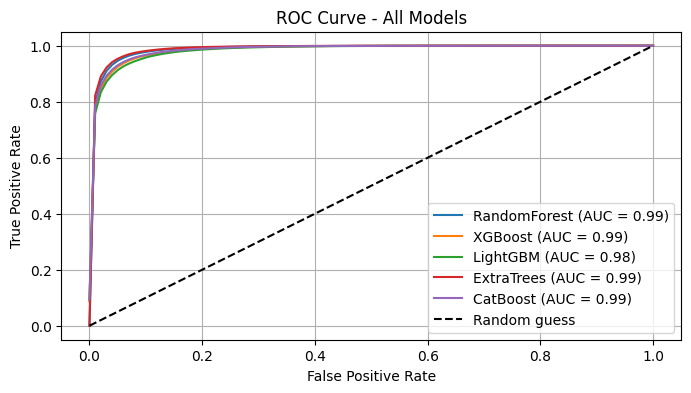

In [20]:
plt.figure(figsize=(8, 4))
for model_name, (fpr, tpr) in roc_results.items():
    auc = performance_summary[model_name]["auc"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Models")
plt.legend()
plt.grid(True)
plt.show()


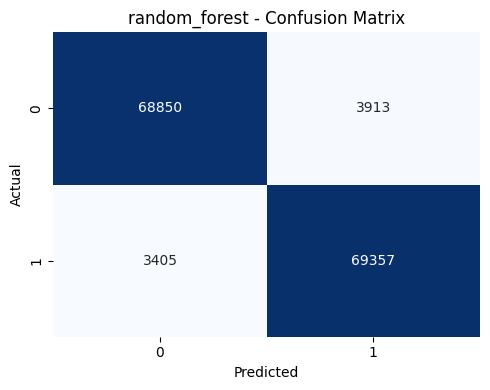

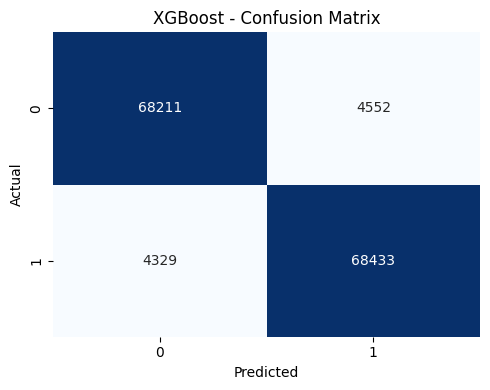

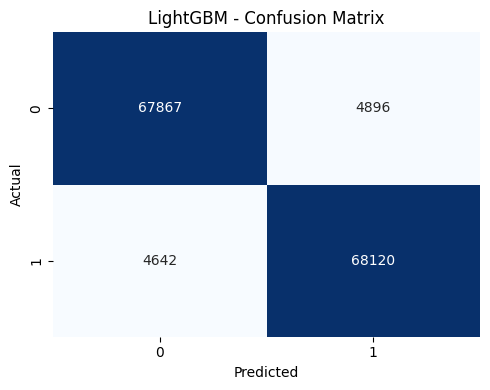

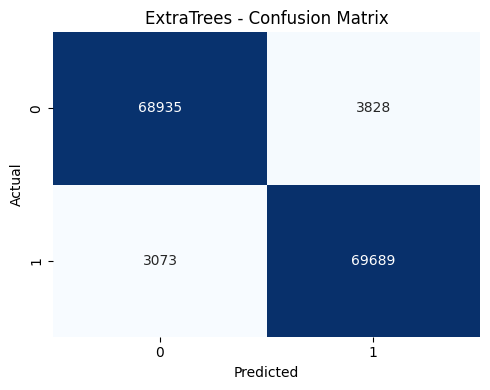

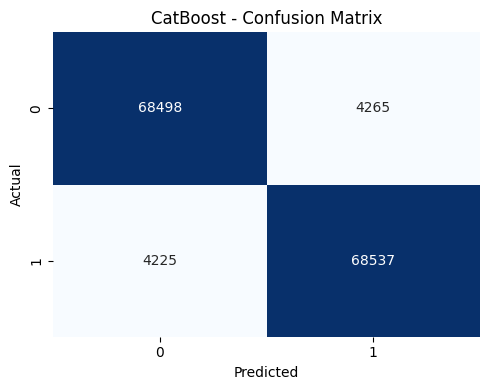


Model Performance Summary on Test Set:
        Model  Accuracy  Precision  Recall  F1-Score
random_forest    0.9497     0.9466  0.9532    0.9499
      XGBoost    0.9390     0.9376  0.9405    0.9391
     LightGBM    0.9345     0.9329  0.9362    0.9346
   ExtraTrees    0.9526     0.9479  0.9578    0.9528
     CatBoost    0.9417     0.9414  0.9419    0.9417


In [21]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Load Test Set ---
test_df = pd.read_csv(r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\test_set_final.csv")
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

# --- Load Saved Scaler ---
scaler = joblib.load("saved_models_final/standard_scaler.pkl")
X_test_scaled = scaler.transform(X_test)

# --- Model Paths ---
model_paths = {
    "random_forest":"saved_models_final/RandomForest_best_model.pkl",
    "XGBoost": "saved_models_final/XGBoost_best_model.pkl",
    "LightGBM": "saved_models_final/LightGBM_best_model.pkl",
    "ExtraTrees": "saved_models_final/ExtraTrees_best_model.pkl",
    "CatBoost": "saved_models_final/CatBoost_best_model.pkl",
}

# --- Performance Summary ---
summary = []

# --- Plotting Helper ---
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# --- Evaluate Models ---
for name, path in model_paths.items():
    model = joblib.load(path)

    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    summary.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4),
    })

    plot_conf_matrix(cm, name)

# --- Print Summary Table ---
summary_df = pd.DataFrame(summary)
print("\nModel Performance Summary on Test Set:")
print(summary_df.to_string(index=False))


In [ ]:
############ prediction of a random input test file

In [22]:
import os
import numpy as np
import pandas as pd
from math import acos, degrees
from itertools import combinations
from numpy.linalg import norm
from scipy.spatial import cKDTree
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# --- Function Definitions ---
def parse_obj(filepath):
    vertices, edges = [], []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = list(map(float, line.strip().split()[1:4]))
                vertices.append(parts)
            elif line.startswith('l '):
                i, j = map(int, line.strip().split()[1:3])
                edges.append((i - 1, j - 1))  # convert to 0-based
    return np.array(vertices), edges

def compute_features(vertices, edges, k_neighbors=3):
    edge_set = set((min(i, j), max(i, j)) for i, j in edges)
    tree = cKDTree(vertices)

    features = []
    for i, j in combinations(range(len(vertices)), 2):
        p1, p2 = vertices[i], vertices[j]
        vec = p2 - p1
        dist = norm(vec)
        midpoint = (p1 + p2) / 2
        midpoint_height = midpoint[2]
        elevation_diff = abs(p1[2] - p2[2])

        horizontal = vec.copy(); horizontal[2] = 0
        angle_with_horizontal = degrees(acos(
            np.clip(np.dot(vec, horizontal) / (norm(vec) * norm(horizontal) + 1e-6), -1, 1)
        ))

        density_i = len(tree.query_ball_point(p1, r=2.0))
        density_j = len(tree.query_ball_point(p2, r=2.0))
        local_density = (density_i + density_j) / 2

        def get_planarity_score(point):
            _, idx = tree.query(point, k=k_neighbors)
            neighbor_pts = vertices[idx]
            cov = np.cov(neighbor_pts.T)
            eigvals = np.linalg.eigvalsh(cov)
            return eigvals[0] / (eigvals.sum() + 1e-6)

        planarity = (get_planarity_score(p1) + get_planarity_score(p2)) / 2

        def get_normal(point):
            _, idx = tree.query(point, k=k_neighbors)
            neighbor_pts = vertices[idx]
            cov = np.cov(neighbor_pts.T)
            eigvals, eigvecs = np.linalg.eigh(cov)
            return eigvecs[:, np.argmin(eigvals)]

        n1 = get_normal(p1)
        n2 = get_normal(p2)
        normal_diff = degrees(acos(np.clip(np.dot(n1, n2), -1, 1)))

        angles = []
        for k in range(len(vertices)):
            if k != j and ((i, k) in edge_set or (k, i) in edge_set):
                vec2 = vertices[k] - p1
                angle = degrees(acos(
                    np.clip(np.dot(vec, vec2) / (norm(vec) * norm(vec2) + 1e-6), -1, 1)
                ))
                angles.append(angle)
        angle_to_others = np.mean(angles) if angles else 0

        label = int((i, j) in edge_set or (j, i) in edge_set)

        features.append({
            'v1': i, 'v2': j,
            'distance': dist,
            'midpoint_height': midpoint_height,
            'angle_with_horizontal': angle_with_horizontal,
            'elevation_difference': elevation_diff,
            'local_density': local_density,
            'planarity_score': planarity,
            'normal_difference': normal_diff,
            'angle_to_other_edges': angle_to_others,
            'label': label
        })

    return features

# === Set Path to Single OBJ File ===
obj_file = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\dataset\Entry-level\train\wireframe\333.obj"

# --- Feature Extraction ---
try:
    verts, edgelist = parse_obj(obj_file)
    feats = compute_features(verts, edgelist)
    for f in feats:
        f["file"] = os.path.basename(obj_file)
    all_features = feats
except Exception as e:
    print(f"Error processing {obj_file}: {e}")
    all_features = []

# --- Save Raw Feature CSV ---
df = pd.DataFrame(all_features)
df.to_csv("raw_vertex_pair_features.csv", index=False)

# --- Apply SMOTE ---
X = df.drop(columns=["v1", "v2", "file", "label"])
y = df["label"]

# Scale before SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# --- Add v1 and v2 back ---
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["v1"] = df["v1"].iloc[:len(df_resampled)]
df_resampled["v2"] = df["v2"].iloc[:len(df_resampled)]
df_resampled["label"] = y_resampled

# --- Save the balanced dataset ---
df_resampled.to_csv("balanced_test_features_with_v1_v2_and_labels_final.csv", index=False)
print("Balanced dataset with 'v1', 'v2', and 'label' columns saved.")


Balanced dataset with 'v1', 'v2', and 'label' columns saved.


In [23]:
import pandas as pd

# Step 1: Load the dataset
df = pd.read_csv(r'balanced_test_features_with_v1_v2_and_labels_final.csv')

# Step 2: Define features to drop
columns_to_drop = ['midpoint_height', 'planarity_score']

# Drop only the columns that actually exist in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_updated = df.drop(columns=columns_to_drop)

# Step 3: Save the updated dataset
df_updated.to_csv("updated_features_without_least_important_final_test.csv", index=False)

print("✅ Updated dataset saved as 'updated_features_without_least_important_final_test.csv'")


✅ Updated dataset saved as 'updated_features_without_least_important_final_test.csv'


In [25]:
import pandas as pd
import numpy as np
import open3d as o3d
import joblib

# === Step 1: Load the Trained Model ===
model_path = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\saved_models_final\ExtraTrees_best_model.pkl"
model = joblib.load(model_path)

# === Step 2: Load Test Data ===
test_csv_path = r"updated_features_without_least_important_final_test.csv"
df_test = pd.read_csv(test_csv_path)

# === Step 3: Load the saved Scaler ===
scaler_path = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\saved_models_final\standard_scaler.pkl"
scaler = joblib.load(scaler_path)

# === Step 4: Prepare and Scale Test Features ===
feature_columns = [
    'distance', 'angle_with_horizontal',
    'elevation_difference', 'local_density',
    'normal_difference', 'angle_to_other_edges'
]
X_test = df_test[feature_columns].values
X_test_scaled = scaler.transform(X_test)

# === Step 5: Predict Probabilities ===
y_pred_probs = model.predict_proba(X_test_scaled)
df_test['probability'] = y_pred_probs[:, 1]

# === Step 6: Dynamic Thresholding Based on Top-K% Confident Edges ===
top_k_percent = 0.50 # Keep top 55% confident edges
threshold_dynamic = df_test['probability'].quantile(1 - top_k_percent)
df_test['prediction'] = (df_test['probability'] >= threshold_dynamic).astype(int)

# === Step 7: Extract Predicted Edges ===
# Handle NaN values in 'v1' and 'v2'
df_test = df_test.dropna(subset=['v1', 'v2'])

# Now you can safely convert 'v1' and 'v2' to integers
predicted_edges = [
    (int(row['v1']), int(row['v2']))
    for idx, row in df_test.iterrows() if row['prediction'] == 1
]

#print("✅ Number of predicted edges after dynamic thresholding:", len(predicted_edges))

# === Step 8: Save Predictions and Probabilities to CSV ===
predictions_csv_path = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\predictions_with_probabilities.csv"
df_test[['v1', 'v2', 'prediction', 'probability']].to_csv(predictions_csv_path, index=False)
print(f"✅ Predictions and probabilities saved to: {predictions_csv_path}")

# === Step 9: Load OBJ vertices ===
def parse_obj_vertices(filepath):
    verts = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = list(map(float, line.strip().split()[1:4]))
                verts.append(parts)
    return np.array(verts)

obj_path = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\dataset\Entry-level\train\wireframe\333.obj"
verts_np = parse_obj_vertices(obj_path)
# Offset the vertices used for lines slightly in the Z-direction
offset_verts_np = verts_np.copy()
offset_verts_np[:, 2] += 0.001  # Add a small offset in Z-axis

# === Step 10: Visualize with Open3D ===
# Create point cloud from vertices
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(verts_np)
pcd.paint_uniform_color([0.5, 0.5, 0.5])  # Gray points

# Create LineSet with black edges
# Create LineSet with slightly offset vertices to avoid flickering
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(offset_verts_np)  # use offset
line_set.lines = o3d.utility.Vector2iVector(predicted_edges)
line_set.paint_uniform_color([0, 0, 0])  # Black edges


# Visualize
print("🚀 Visualizing predicted edges and vertices with black color...")
o3d.visualization.draw_geometries([pcd, line_set], window_name="Predicted Edges with Black Coloring")


C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Predictions and probabilities saved to: C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\predictions_with_probabilities.csv
🚀 Visualizing predicted edges and vertices with black color...
